# Percent Hypoxic
at each node calculate the percentage of the water volume 'under' that node that has hypoxic water (<2 mg/L).  Instead of two colors (on/off) there is a colorbar ranging from 0% - 100%.

In [17]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

In [18]:
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']

run_file="/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/SOG_NB/DOXG/wqm_baseline/daily_min_DOXG.nc"
DO_thresh=2
        
model_var="DOXG"
plt.rc('axes', titlesize=16)     # fontsize of the axes title

# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

# Pull directory name from run_file path
run_type = run_file.split('/')[-2]
# Isolate run tag for image file naming
run_tag = run_type.split("_")[0]
if run_tag=='wqm': # for baseline and reference cases
    run_tag = run_type.split("_")[1]
        
# Load minimum DO results from scenario
MinDO_full={}
MinDO={}
try: 
    with xarray.open_dataset(run_file) as ds:
        print([*ds])
        MinDO_full[run_type]=ds[f'{model_var}_daily_min']
        # Sub-sample nodes (from 16012 nodes to 7494)
        MinDO[run_type]=MinDO_full[run_type][:,:,gdf['node_id']-1]
        print(MinDO[run_type].shape)
except FileNotFoundError:
    print(f'File Not Found: {run_file}')

# Get number of days and nodes
[ndays,nlevels,nnodes]=MinDO[run_type].shape

# Create array of Dissolved Oxygen threshold values
if DO_thresh=='DO_standard':
    DO_thresh=gdf['DO_std']
    DO_thresh3D = np.ones(
        (nnodes,nlevels,ndays))*np.array(DO_thresh).reshape(nnodes,1,1)
else:
    DO_thresh3D = np.ones((nnodes,nlevels,ndays))*int(DO_thresh)      
        
# Calculate volume for volume days
volume = np.asarray(gdf.volume)
depth_fraction = np.array(ssm['siglev_diff'])/100
volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))
volume3D = np.repeat(volume2D.transpose()[np.newaxis, :, :], 361, axis=0)

# Initialize dictionaries
DOXGBelowThresh={} # Boolean where DO<threshold

# Calculate DO below threshold
DOXGBelowThresh[run_type] = MinDO[run_type]<=DO_thresh3D.transpose() 



['DOXG_daily_min']
(361, 10, 4144)


In [19]:
volume_anoxic={}
percent_volume_anoxic={}
# element-wise multiplication of two 361x10x4144 arrays
volume_anoxic[run_type]=np.multiply(volume3D,DOXGBelowThresh[run_type])
#add impaired volume across depth-levels and nodes
percent_volume_anoxic[run_type]=100*np.divide(
    volume_anoxic[run_type].sum(axis=1),  # 361 X 4144
    np.repeat(volume[np.newaxis, :], 361, axis=0)  #361 x 4144
)
percent_volume_anoxic[run_type].shape

(361, 4144)

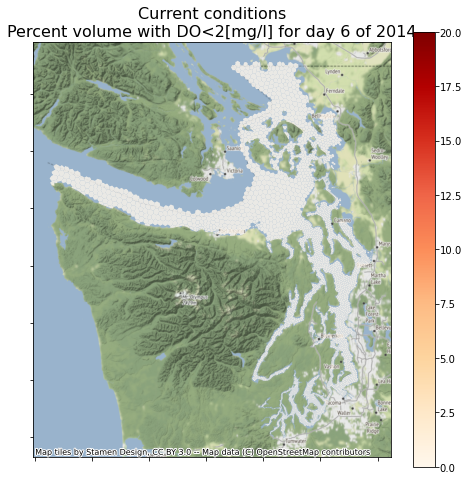

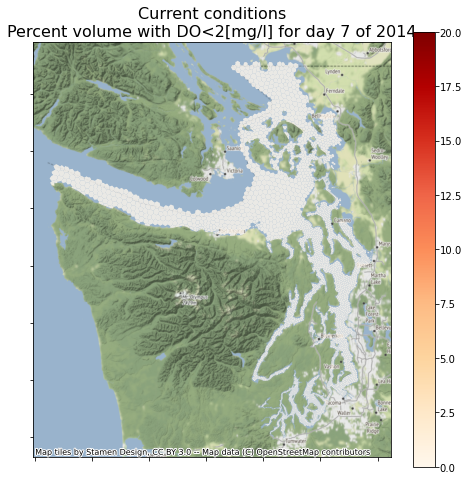

In [25]:
case='SOG_NB'
processed_netcdf_dir = pathlib.Path(
    ssm['paths']['processed_output'])/case/model_var
output_directory = processed_netcdf_dir/run_type/'movies'/'percent_anoxic'
# create output directory, if is doesn't already exist 
# see https://docs.python.org/3/library/os.html#os.makedirs
if os.path.exists(output_directory)==False:
    print(f'creating: {output_directory}')
    os.umask(0) #clears permissions
    if os.path.exists(processed_netcdf_dir/run_type/'movies')==False:
        os.makedirs(
            processed_netcdf_dir/run_type/'movies', 
            mode=0o777,exist_ok=True)
        os.makedirs(processed_netcdf_dir/run_type/'movies'/'percent_anoxic',
            mode=0o777,exist_ok=True)
    else:
        os.makedirs(processed_netcdf_dir/run_type/'movies'/'percent_anoxic',
            mode=0o777,exist_ok=True)

# Plot percent volume anoxic for each day
for day in range(2):
    model_day = day + ssm['run_information']['spin_up_days'] + 1
    output_file = output_directory/f'{case}_{run_tag}_percentAnoxic_wc_{model_day}.png'

    gdf['BelowThresh']=percent_volume_anoxic[run_type][day,:]
    
    fig, axs = plt.subplots(1,1, figsize = (8,8))
    #~~~ Below threshold (red) and above threshold (blue) nodes ~~~
    gdf.plot('BelowThresh',
        ax=axs,
        legend=True,
        cmap='OrRd',
        vmin=0, vmax=20,
        label='percent volume DO>=2[mg/l]', alpha = 0.8)
    #~~~ Location map ~~~
    cx.add_basemap(axs, crs=gdf.crs,alpha=1)
    if run_tag == 'baseline':
        axs.set_title(
            f'Current conditions\nPercent volume with DO<2[mg/l], day {model_day} of 2014')
    else:
        axs.set_title(f'{run_tag}\nPercent volume with DO<2[mg/l], day {model_day} of 2014')

    axs.set_xticklabels('')
    axs.set_yticklabels('')

    plt.show()
    #plt.savefig(output_file, bbox_inches='tight', format='png')
    #plt.clf() #clear figure and memory